In [56]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

In [57]:
S0=100
K=100
r=0.05
T=1
N=5
sigma=0.15

opttype='C'

In [58]:
# Black-Scholes 


def black_scholes(S, K, T, r, sigma, option_type='call'):
    """

    Parameters:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate 
        sigma (float): Volatility of the stock price
        option_type (str): 'call' for call option, 'put' for put option

    Returns:
        float: Theoretical option price
    """
    # Compute d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'C':
        # Call option price
        price = S * sp.norm.cdf(d1) - K * np.exp(-r * T) * sp.norm.cdf(d2)
    elif option_type == 'P':
        # Put option price
        price = K * np.exp(-r * T) * sp.norm.cdf(-d2) - S * sp.norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price

Formula for Stock price at node i,j:

S(i,j)=S0* u^(j)*d^(i-j)

Binomial Tree 

In [59]:
import numpy as np

def binomial_tree(S0, K, r, T, N, sigma, opttype="C"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # Initialise the stock price tree as a 2D array
    S = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            S[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Initialise a 2D array for option values
    C = np.zeros((N + 1, N + 1))

    # Initialise option values at maturity
    for j in range(N + 1):
        if opttype == "C":  # Call option
            C[j, N] = max(0, S[j, N] - K)
        elif opttype == "P":  # Put option
            C[j, N] = max(0, K - S[j, N])

    # Step backwards through the tree
    for i in np.arange(N - 1, -1, -1):
        for j in range(i + 1):
            C[j, i] = disc * (q * C[j+1, i+1] + (1 - q) * C[j, i+1])

    return  C,S



In [60]:
C,S=binomial_tree(S0,K,r,T,N,sigma,opttype)

# Display stock price tree
print("Stock Price Tree:")
for i in range(N + 1):
    for j in range(i + 1):
        print(f"{S[j, i]:8.4f}", end=" ")
    print()

# Display option value tree
print("\nOption Value Tree:")
for i in range(N + 1):
    for j in range(i + 1):
        print(f"{C[j, i]:8.4f}", end=" ")
    print()

Stock Price Tree:
100.0000 
 93.5118 106.9383 
 87.4447 100.0000 114.3580 
 81.7711  93.5118 106.9383 122.2926 
 76.4657  87.4447 100.0000 114.3580 130.7776 
 71.5045  81.7711  93.5118 106.9383 122.2926 139.8514 

Option Value Tree:
  8.8380 
  4.1261  12.7282 
  1.1704   6.5407  17.8569 
  0.0000   2.1182  10.1604  24.2727 
  0.0000   0.0000   3.8337  15.3531  31.7726 
  0.0000   0.0000   0.0000   6.9383  22.2926  39.8514 


In [61]:

def binomial_tree_vectorized(S0, K, r, T, N, sigma, opttype="C"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)
 
    disc = np.exp(-r * dt)

    # Vectorized stock price tree
    j = np.arange(N + 1).reshape(-1, 1)  # Column vector for "up" steps
    i = np.arange(N + 1)                 # Row vector for total steps
    S = S0 * (u ** j) * (d ** (i - j))   # Vectorized calculation

    # Option values at maturity
    if opttype == "C":
        C = np.maximum(S[:, -1] - K, 0)  # Call option payoff
    elif opttype == "P":
        C = np.maximum(K - S[:, -1], 0)  # Put option payoff

    # Backward induction for option pricing
    for i in np.arange(N - 1, -1, -1):
        C[:i+1] = disc * (q * C[1:i+2] + (1 - q) * C[:i+1])

    return C[0], S  # Return option price at root and stock price tree


In [62]:
C,S=binomial_tree_vectorized(S0,K,r,T,N,sigma,opttype)

# Display stock price tree
print("Stock Price Tree:")
for i in range(N + 1):
    for j in range(i + 1):
        print(f"{S[j, i]:8.4f}", end=" ")
    print()

print("Option Price:",C)

Stock Price Tree:
100.0000 
 93.5118 106.9383 
 87.4447 100.0000 114.3580 
 81.7711  93.5118 106.9383 122.2926 
 76.4657  87.4447 100.0000 114.3580 130.7776 
 71.5045  81.7711  93.5118 106.9383 122.2926 139.8514 
Option Price: 8.838016940895734


In [63]:
C_b=black_scholes(S0, K, T, r, sigma, opttype)

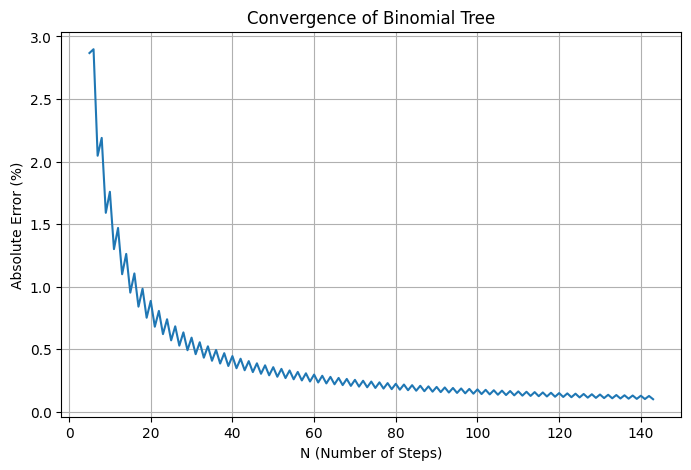

In [64]:

er = []
n_values = []

for i in range(5, 200):
    N = i
    C, S = binomial_tree_vectorized(S0, K, r, T, N, sigma, opttype)
    
    er_curr = abs((C_b - C) / C_b * 100)  # Absolute error
    er.append(er_curr)
    n_values.append(N)  # Store N values

    if er_curr < 0.1:
       
        break

# Plot Error vs. N
plt.figure(figsize=(8, 5))
plt.plot(n_values, er, linestyle='-')
plt.xlabel("N (Number of Steps)")
plt.ylabel("Absolute Error (%)")
plt.title("Convergence of Binomial Tree")
plt.grid(True)
plt.show()
